In [7]:
import numpy as np
import pandas as pd
import torch
import copy
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
import spconv.pytorch as spconv
import matplotlib.pyplot as plt
import mytools
import mymodels

# Prepare Data

In [8]:
# Read pandas dataframe with all information about sparse training tensors
file_loc = '/home/majd/sparse_training_arrows/'
st_info = pd.read_pickle(file_loc+'sparse_tensor_info.pk')
st_info

,dir,offset
0,"[-0.5520938254267553, -0.825713352783964, -0.1...","[0, 0, 0]"
1,"[0.3657888590215906, 0.4602307668281921, 0.808...","[0, 0, 0]"
2,"[0.9315045909480836, 0.35431361511161974, 0.08...","[0, 0, 0]"
3,"[0.17431689982853446, -0.9752304574243912, 0.1...","[0, 0, 0]"
4,"[-0.13304236665754948, 0.7513837952040148, 0.6...","[0, 0, 0]"
...,...,...
95,"[-0.23104568980665205, 0.5956136249445827, 0.7...","[0, 0, 0]"
96,"[0.91419301977937, 0.2786905690823306, -0.2942...","[0, 0, 0]"
97,"[-0.12297952315221822, -0.9187204705663674, -0...","[0, 0, 0]"
98,"[-0.6005107791429211, -0.2983086399835448, -0....","[0, 0, 0]"


In [9]:
# Make custom dataset
MyDataset = mytools.CustomDataset(dir_loc = file_loc, st_info = st_info)

# Split datat into training, validation, and testing sets
train_dataset, val_dataset = torch.utils.data.random_split(MyDataset,[0.8, 0.2], generator=torch.Generator().manual_seed(42))

print("Training samples: ", len(train_dataset))
print("Validation samples: ", len(val_dataset))

# Create training and validation DataLoaders
batch_size = 256
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

Training samples:  80
Validation samples:  20


In [10]:
# Print tensor shapes
for X_plot, y_plot, offset_plot in train_dataloader:
    print(f"Shape of X [N, C, H, W, D]: {X_plot.shape}")
    print(f"Shape of y: {y_plot.shape} {y_plot.dtype}")
    print("Offsets: ", offset_plot.shape)
    break


Shape of X [N, C, H, W, D]: torch.Size([80, 120, 120, 120, 1])
Shape of y: torch.Size([80, 3]) torch.float32
Offsets:  torch.Size([80, 3])


In [11]:
#Record shape of voxel grid
grid_shape = X_plot.shape[1:4]
print("Voxel grid shape: " , grid_shape)

Voxel grid shape:  torch.Size([120, 120, 120])


# Visualize a sample

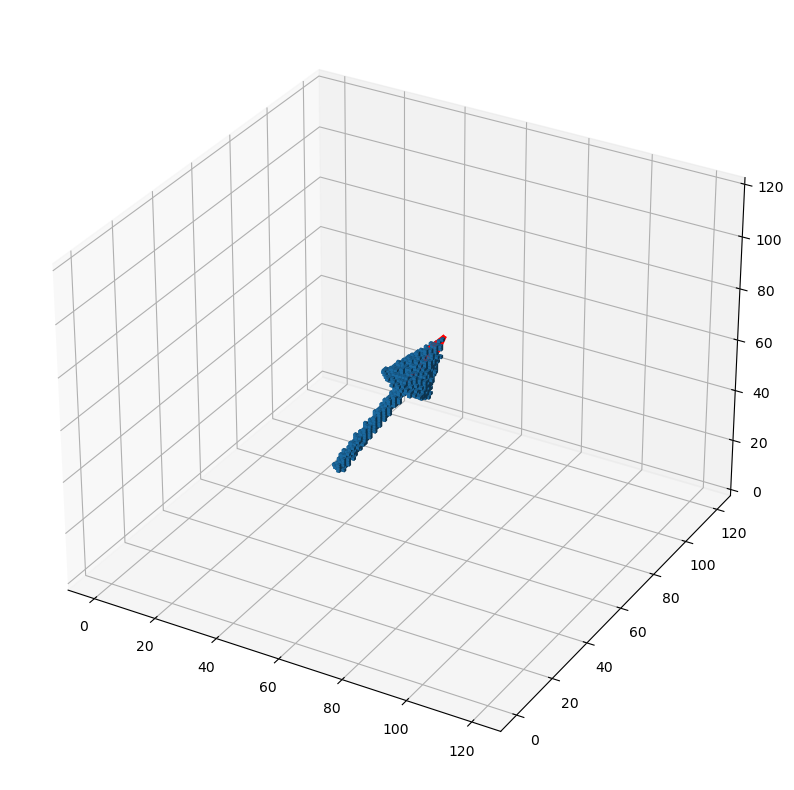

In [12]:
# Plot an example as a sanity check

# x/y/z length being kept in cm
eff_l = mytools.voxel_grid['eff_l']
# Voxel size in cm
vox_l = mytools.voxel_grid['vox_l']

#Convert to dense, reshape and convert to numpy
X_plot = X_plot.to_dense().reshape(-1, 1, 120, 120, 120).numpy()

index = 2
mytools.plot_tensor_dir(tensor = X_plot[index], start = offset_plot[index].numpy(), direction = y_plot[index].numpy(), eff_l=eff_l, vox_l=vox_l)



# Initialize Convnet

In [13]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

model = mymodels.spConvnet_subM(shape = grid_shape ).to(device)
print(model)

Using cuda device
spConvnet_subM(
  (net): SparseSequential(
    (0): SubMConv3d(1, 32, kernel_size=[7, 7, 7], stride=[1, 1, 1], padding=[0, 0, 0], dilation=[1, 1, 1], output_padding=[0, 0, 0], algo=ConvAlgo.Native)
    (1): ReLU()
    (2): SubMConv3d(32, 40, kernel_size=[5, 5, 5], stride=[1, 1, 1], padding=[0, 0, 0], dilation=[1, 1, 1], output_padding=[0, 0, 0], algo=ConvAlgo.Native)
    (3): ReLU()
    (4): SparseConv3d(40, 50, kernel_size=[6, 6, 6], stride=[2, 2, 2], padding=[0, 0, 0], dilation=[1, 1, 1], output_padding=[0, 0, 0], algo=ConvAlgo.Native)
    (5): ReLU()
    (6): SparseMaxPool3d(kernel_size=[2, 2, 2], stride=[2, 2, 2], padding=[0, 0, 0], dilation=[1, 1, 1], algo=ConvAlgo.MaskImplicitGemm)
    (7): SparseConv3d(50, 30, kernel_size=[3, 3, 3], stride=[2, 2, 2], padding=[0, 0, 0], dilation=[1, 1, 1], output_padding=[0, 0, 0], algo=ConvAlgo.MaskImplicitGemm)
    (8): ReLU()
    (9): SparseConv3d(30, 10, kernel_size=[3, 3, 3], stride=[1, 1, 1], padding=[0, 0, 0], dilation=[1

# Train the model

In [14]:
# Specify optimizer
optimizer = torch.optim.Adam(params = model.parameters(), lr=0.0001, betas=(0.94, 0.999), eps=1e-07)


In [21]:
# Implement early stopping in training loop
# Stop if validation loss has not decreased for the last [patience] epochs
# The model with the lowest loss is stored
patience = 2

Training_losses = np.array([])
Validation_losses = np.array([])

epochs = 1000
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    Training_losses = np.append(Training_losses, mytools.train(train_dataloader, model, mytools.CSloss, optimizer, device))
    Validation_losses = np.append(Validation_losses, mytools.validate(val_dataloader, model, mytools.CSloss, device))
    
    # Keep a running copy of the model with the lowest loss
    if Validation_losses[-1] == np.min(Validation_losses):
        final_model = copy.deepcopy(model)
    
    if len(Validation_losses) > patience:
        if np.sum((Validation_losses[-1*np.arange(patience)-1] - Validation_losses[-1*np.arange(patience)-2]) < 0) == 0:
            print("Stopping early!")
            break
            
print("Done!")

Epoch 1
-------------------------------
Current batch training loss: -0.983951  [    0/   80]
Training loss: -0.983951
Validation loss: -0.979916 

Epoch 2
-------------------------------
Current batch training loss: -0.979559  [    0/   80]
Training loss: -0.979559
Validation loss: -0.978081 

Epoch 3
-------------------------------
Current batch training loss: -0.977496  [    0/   80]
Training loss: -0.977496
Validation loss: -0.978710 

Epoch 4
-------------------------------
Current batch training loss: -0.978232  [    0/   80]
Training loss: -0.978232
Validation loss: -0.981398 

Epoch 5
-------------------------------
Current batch training loss: -0.981256  [    0/   80]
Training loss: -0.981256
Validation loss: -0.985218 

Epoch 6
-------------------------------
Current batch training loss: -0.985495  [    0/   80]
Training loss: -0.985495
Validation loss: -0.989104 

Epoch 7
-------------------------------
Current batch training loss: -0.989711  [    0/   80]
Training loss: -0.

# Visualize Training

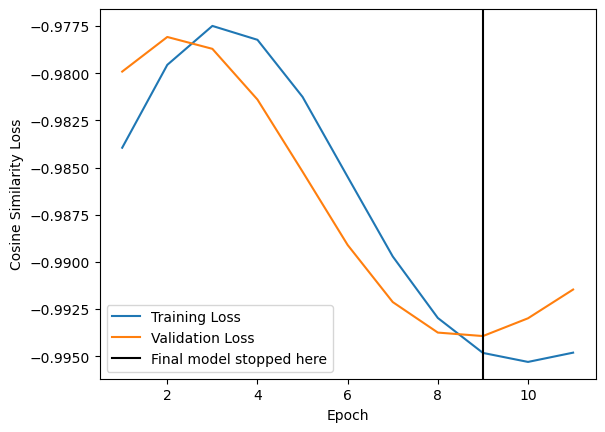

In [22]:
# Plot Training and Validation Loss
# Indicate where the final model stopped training

best_epoch = np.argmin(Validation_losses)+1

plt.plot(np.arange(len(Training_losses))+1,Training_losses,label="Training Loss")
plt.plot(np.arange(len(Validation_losses))+1,Validation_losses,label="Validation Loss")
plt.axvline(best_epoch,label="Final model stopped here",color='k')
plt.xlabel('Epoch')
plt.ylabel('Cosine Similarity Loss')
plt.legend()


# Save the Model

In [23]:
torch.save(final_model, "../3D_Heteroscedastic_Convnet_models/3D_CNN_subM-256_arrow.pt")
print("Saved PyTorch Model State to ../3D_Heteroscedastic_Convnet_models/3D_CNN_subM-256_arrow.pt")

Saved PyTorch Model State to ../3D_Heteroscedastic_Convnet_models/3D_CNN_subM-256_arrow.pt


# Test the Model